<h2><center> Welcome to the Monthly Insurance Claim Prediction Challenge Starter Notebook</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=18IZFQ9-HParnXoXKSKQQWDWUsamprUk5" width = "750" height = '500'/>

*About the problem*
> Short-term insurance claims are one of the largest costs in the insurance industry, and are extremely difficult to forecast. Zimnat Insurance wants to predict the value of future claims per client, in order to better forecast annual costs.

*The objective of this challenge is*:
> To create a machine learning model to predict how much a client will claim from Zimnat per month for a whole year. 

The solution will aid Zimnat in being better prepared to address claims that are submitted, and improve customer satisfaction by alerting clients to possible claims they will make in the future. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Dataset datatypes](#Datatypes)
7. [Feature engineering](#Engineering)
8. [Date features EDA](#Dates)
9. [Branch features EDA](#Branch)
10. [Categorical features](#Categorical)
11. [Preprocess test dataset](#Preprocess)
12. [Modelling](#Modelling)
13. [Making predictions of the test set and creating a submission file](#Predictions)
14. [More Tips](#Tips)

<a name="Libraries"></a>
## 1. Importing libraries


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [ ]:
def resume_table(data):
    #print(f'Data Shape: {data.shape}')
    summary = (pd
               .DataFrame(data.dtypes, columns=['dtypes'])
               .reset_index()
               .rename(columns={'index': 'name'}))
    summary.loc[:, 'missing'] = data.isna().sum().values
    summary.loc[:, '%missing'] = np.round(summary.missing / data.shape[0] * 100, 2)
    summary.loc[:, 'uniques'] = data.nunique().values
    return summary, data.shape

In [ ]:
# Load files
train = pd.read_csv('/content/drive/MyDrive/ZINDI Real/train.csv')
policies = pd.read_csv('/content/drive/MyDrive/ZINDI Real/policies.csv')
test = pd.read_csv('/content/drive/MyDrive/ZINDI Real/test.csv')
samplesubmission = pd.read_csv('/content/drive/MyDrive/ZINDI Real/SampleSubmission.csv')

# Preview train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000


In [ ]:
# Preview policies dataset
policies.head()

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
0,pol000006995,prod00033,2017-07-01 08:24:55.800,2017-07-01 00:00:00.000,2018-07-01 00:00:00.000,ag00005,cob00035,ct0001,rf0002,br00002
1,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00009,ct0003,rf0001,br00006
2,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00031,ct0003,rf0001,br00006
3,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00031,ct0003,rf0001,br00002
4,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00009,ct0003,rf0001,br00002


In [ ]:
test[test['policy_number']=='pol000009828']

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch
1822,ID_IKA9OJWSZMF7,pol000009828,claim0011437,4500.00000,prod00005,ag00226,cob00009,rt00032,2018-10-15,ct0003,rf0001,pc0007,sc00024,br00006


In [ ]:
# Preview test dataset
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch
0,ID_4RO0KZI9BBW2,pol000007115,claim0005757,300000.00000,prod00005,ag00068,cob00009,rt00032,2021-03-11,ct0003,rf0001,pc0007,sc00029,br00004
1,ID_GTE9ZUJ9GZ97,pol000006008,claim0003037,2700000.00000,prod00015,ag00064,cob00034,rt00023,2020-06-25,ct0001,rf0003,pc0007,sc00022,br00002
2,ID_RUVIYRKWZ4RG,pol000007651,claim0006507,4071352.00000,prod00012,ag00021,cob00016,rt00015,2019-03-14,ct0001,rf0001,pc0011,sc00049,br00001
3,ID_J81X8SWU6JYN,pol000010981,claim0013636,0.00000,prod00002,ag00037,cob00002,rt00002,2018-12-04,ct0001,rf0002,pc0002,sc00012,br00005
4,ID_94NM3JJAWWOQ,pol000005926,claim0001750,1607178.00000,prod00015,ag00037,cob00034,rt00023,2019-09-18,ct0001,rf0003,pc0007,sc00022,br00002


In [ ]:
# Preview sample submission file
samplesubmission.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,0
1,ID_GTE9ZUJ9GZ97,0
2,ID_RUVIYRKWZ4RG,0
3,ID_J81X8SWU6JYN,0
4,ID_94NM3JJAWWOQ,0


In [ ]:
resume_table(policies)

(                name  dtypes  missing  %missing  uniques
 0      policy_number  object        0   0.00000     5217
 1       product_code  object        0   0.00000       37
 2         trans_date  object        0   0.00000    20836
 3          from_date  object        0   0.00000     1431
 4            to_date  object        0   0.00000     1369
 5              agent  object        0   0.00000      223
 6  class_of_business  object       46   0.15000       37
 7        client_type  object        0   0.00000        3
 8  renewal_frequency  object        0   0.00000        5
 9             branch  object        0   0.00000       11, (30371, 10))

In [ ]:
policies=policies.drop_duplicates(subset=['policy_number'])

In [ ]:
resume_table(policies)

(                name  dtypes  missing  %missing  uniques
 0      policy_number  object        0   0.00000     5217
 1       product_code  object        0   0.00000       37
 2         trans_date  object        0   0.00000     5217
 3          from_date  object        0   0.00000      897
 4            to_date  object        0   0.00000      968
 5              agent  object        0   0.00000      215
 6  class_of_business  object        2   0.04000       34
 7        client_type  object        0   0.00000        3
 8  renewal_frequency  object        0   0.00000        5
 9             branch  object        0   0.00000       11, (5217, 10))

In [ ]:
resume_table(train)

(                 name   dtypes  missing  %missing  uniques
 0            claim_id   object        0   0.00000     9376
 1       policy_number   object       86   0.92000     4076
 2        claim_number   object        0   0.00000     9167
 3         sum_insured  float64        0   0.00000     1299
 4             product   object        0   0.00000       37
 5               agent   object        0   0.00000        8
 6   class_of_business   object        0   0.00000       37
 7           risk_type   object        0   0.00000       50
 8           loss_date   object        0   0.00000     1359
 9         client_type   object        0   0.00000        3
 10  renewal_frequency   object        0   0.00000        5
 11      primary_cause   object        0   0.00000       21
 12    secondary_cause   object        0   0.00000       74
 13             branch   object        0   0.00000       11
 14             target  float64        0   0.00000     6545, (9376, 15))

In [ ]:
resume_table(test)

(                 name   dtypes  missing  %missing  uniques
 0            claim_id   object        0   0.00000     4019
 1       policy_number   object       41   1.02000     2136
 2        claim_number   object        0   0.00000     3995
 3         sum_insured  float64        0   0.00000      820
 4             product   object        0   0.00000       34
 5               agent   object        0   0.00000        8
 6   class_of_business   object        0   0.00000       33
 7           risk_type   object        0   0.00000       43
 8           loss_date   object        0   0.00000     1235
 9         client_type   object        0   0.00000        3
 10  renewal_frequency   object        0   0.00000        5
 11      primary_cause   object        0   0.00000       18
 12    secondary_cause   object        0   0.00000       63
 13             branch   object        0   0.00000       11, (4019, 14))

In [ ]:
# Check size and shape of datasets
train.shape, policies.shape, test.shape, samplesubmission.shape

((9376, 15), (5217, 10), (4019, 14), (4019, 2))

#**merge** : 

In [ ]:
policies_cols=['policy_number','product_code','trans_date','from_date','to_date']

In [ ]:
new_all_data_train = pd.merge(train ,policies[policies_cols], on='policy_number', how = 'left')
new_all_data_test = pd.merge(test ,policies[policies_cols], on='policy_number', how = 'left')

In [ ]:
resume_table(new_all_data_test)

(                 name   dtypes  missing  %missing  uniques
 0            claim_id   object        0   0.00000     4019
 1       policy_number   object       41   1.02000     2136
 2        claim_number   object        0   0.00000     3995
 3         sum_insured  float64        0   0.00000      820
 4             product   object        0   0.00000       34
 5               agent   object        0   0.00000        8
 6   class_of_business   object        0   0.00000       33
 7           risk_type   object        0   0.00000       43
 8           loss_date   object        0   0.00000     1235
 9         client_type   object        0   0.00000        3
 10  renewal_frequency   object        0   0.00000        5
 11      primary_cause   object        0   0.00000       18
 12    secondary_cause   object        0   0.00000       63
 13             branch   object        0   0.00000       11
 14       product_code   object       41   1.02000       34
 15         trans_date   object       41

In [ ]:
resume_table(new_all_data_train)

(                 name   dtypes  missing  %missing  uniques
 0            claim_id   object        0   0.00000     9376
 1       policy_number   object       86   0.92000     4076
 2        claim_number   object        0   0.00000     9167
 3         sum_insured  float64        0   0.00000     1299
 4             product   object        0   0.00000       37
 5               agent   object        0   0.00000        8
 6   class_of_business   object        0   0.00000       37
 7           risk_type   object        0   0.00000       50
 8           loss_date   object        0   0.00000     1359
 9         client_type   object        0   0.00000        3
 10  renewal_frequency   object        0   0.00000        5
 11      primary_cause   object        0   0.00000       21
 12    secondary_cause   object        0   0.00000       74
 13             branch   object        0   0.00000       11
 14             target  float64        0   0.00000     6545
 15       product_code   object       86

In [ ]:
new_all_data_train=new_all_data_train.drop('policy_number',axis=1)
new_all_data_test=new_all_data_test.drop('policy_number',axis=1)

In [ ]:
new_all_data_train=new_all_data_train.drop('claim_number',axis=1)
new_all_data_test=new_all_data_test.drop('claim_number',axis=1)

In [ ]:
new_all_data_test.head()

,claim_id,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,product_code,trans_date,from_date,to_date
0,ID_4RO0KZI9BBW2,300000.00000,prod00005,ag00068,cob00009,rt00032,2021-03-11,ct0003,rf0001,pc0007,sc00029,br00004,prod00005,2020-11-19 15:55:50.350,2020-12-01 00:00:00.000,2021-03-31 00:00:00.000
1,ID_GTE9ZUJ9GZ97,2700000.00000,prod00015,ag00064,cob00034,rt00023,2020-06-25,ct0001,rf0003,pc0007,sc00022,br00002,prod00015,2018-03-12 16:54:27.007,2018-02-01 00:00:00.000,2018-04-30 00:00:00.000
2,ID_RUVIYRKWZ4RG,4071352.00000,prod00012,ag00021,cob00016,rt00015,2019-03-14,ct0001,rf0001,pc0011,sc00049,br00001,prod00012,2017-07-18 15:42:00.483,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000
3,ID_J81X8SWU6JYN,0.00000,prod00002,ag00037,cob00002,rt00002,2018-12-04,ct0001,rf0002,pc0002,sc00012,br00005,prod00002,2018-01-23 14:46:50.983,2018-01-01 00:00:00.000,2018-12-31 00:00:00.000
4,ID_94NM3JJAWWOQ,1607178.00000,prod00015,ag00037,cob00034,rt00023,2019-09-18,ct0001,rf0003,pc0007,sc00022,br00002,prod00015,2017-10-30 17:07:24.717,2017-09-01 00:00:00.000,2018-08-31 00:00:00.000


In [ ]:
new_all_data_train.head()

,claim_id,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target,product_code,trans_date,from_date,to_date
0,ID_JZ7QWRHH57RO,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000,prod00027,2019-01-30 21:59:01.183,2019-01-02 00:00:00.000,2019-05-01 00:00:00.000
1,ID_KQ5TJMVLJ4EP,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000,prod00005,2018-05-09 10:34:57.480,2018-05-01 00:00:00.000,2018-08-31 00:00:00.000
2,ID_NYHI7WJGGIAE,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000,prod00029,2018-04-06 12:46:23.367,2018-04-01 00:00:00.000,2018-07-31 00:00:00.000
3,ID_ROMMDCXYUXN5,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000,prod00005,2018-03-15 16:57:49.653,2018-02-23 00:00:00.000,2018-06-22 00:00:00.000
4,ID_2OTD9NX8L73D,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000,prod00015,2017-09-15 15:38:29.687,2017-10-01 00:00:00.000,2018-01-31 00:00:00.000


<a name="Statistics"></a>
## 3. Statistical summaries

In [ ]:
# Train statistical summary
new_all_data_train.describe(include = 'all')

,claim_id,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target,product_code,trans_date,from_date,to_date
count,9376,9376.00000,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376.00000,9290,9290,9290,9290
unique,9376,NaN,37,8,37,50,1359,3,5,21,74,11,NaN,37,4076,807,849
top,ID_JZ7QWRHH57RO,NaN,prod00015,ag00037,cob00034,rt00023,2019-08-20,ct0001,rf0002,pc0007,sc00023,br00002,NaN,prod00015,2018-04-21 16:27:54.930,2018-01-01 00:00:00.000,2018-12-31 00:00:00.000
freq,1,NaN,4411,3114,3608,3771,83,6096,4853,7396,2980,3900,NaN,4411,254,1247,1144
mean,NaN,8534789.61723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41464.71125,NaN,NaN,NaN,NaN
std,NaN,112556487.28996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208434.71755,NaN,NaN,NaN,NaN
min,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN
25%,NaN,6500.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.92500,NaN,NaN,NaN,NaN
50%,NaN,50542.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1956.92500,NaN,NaN,NaN,NaN
75%,NaN,420000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12700.64250,NaN,NaN,NaN,NaN


In [ ]:
new_all_data_test.describe(include = 'all')

,claim_id,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,product_code,trans_date,from_date,to_date
count,4019,4019.00000,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,3978,3978,3978,3978
unique,4019,NaN,34,8,33,43,1235,3,5,18,63,11,34,2136,558,574
top,ID_4RO0KZI9BBW2,NaN,prod00015,ag00037,cob00034,rt00023,2019-08-20,ct0001,rf0002,pc0007,sc00023,br00002,prod00015,2018-04-21 16:27:54.930,2018-01-01 00:00:00.000,2018-12-31 00:00:00.000
freq,1,NaN,1940,1319,1622,1664,27,2653,2040,3208,1328,1674,1940,115,540,476
mean,NaN,17881685.99892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,296830977.86562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,7000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,54000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,475500.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above statistical summary, we can deduce some of the following insights:
 - The minimum amount claimed is 0 and the maximum is 7868590.62000
 - There are 11 different branches
 - Majority of the training features are categorical in nature

In [ ]:
# Policies statistical summary
policies.describe(include = 'all', datetime_is_numeric=True)

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
count,5217,5217,5217,5217,5217,5217,5215,5217,5217,5217
unique,5217,37,5217,897,968,215,34,3,5,11
top,pol000006995,prod00005,2017-07-01 08:24:55.800,2017-10-01 00:00:00.000,2018-01-31 00:00:00.000,ag00226,cob00031,ct0003,rf0001,br00001
freq,1,2114,1,477,341,1127,2088,3437,2625,2009


#**ABOUT POLICIES** : 

In [ ]:
policies.head()

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
0,pol000006995,prod00033,2017-07-01 08:24:55.800,2017-07-01 00:00:00.000,2018-07-01 00:00:00.000,ag00005,cob00035,ct0001,rf0002,br00002
1,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00009,ct0003,rf0001,br00006
3,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00031,ct0003,rf0001,br00002
5,pol000006276,prod00005,2017-07-01 10:07:21.287,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00006,cob00009,ct0003,rf0001,br00002
7,pol000009954,prod00005,2017-07-01 10:49:52.300,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00033,cob00031,ct0003,rf0001,br00006


In [ ]:
resume_table(policies)

(                name  dtypes  missing  %missing  uniques
 0      policy_number  object        0   0.00000     5217
 1       product_code  object        0   0.00000       37
 2         trans_date  object        0   0.00000     5217
 3          from_date  object        0   0.00000      897
 4            to_date  object        0   0.00000      968
 5              agent  object        0   0.00000      215
 6  class_of_business  object        2   0.04000       34
 7        client_type  object        0   0.00000        3
 8  renewal_frequency  object        0   0.00000        5
 9             branch  object        0   0.00000       11, (5217, 10))

<a name="Missing"></a>
## 4. Missing values and duplicates

In [ ]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any(), policies.isnull().sum().any()

(True, True, True)

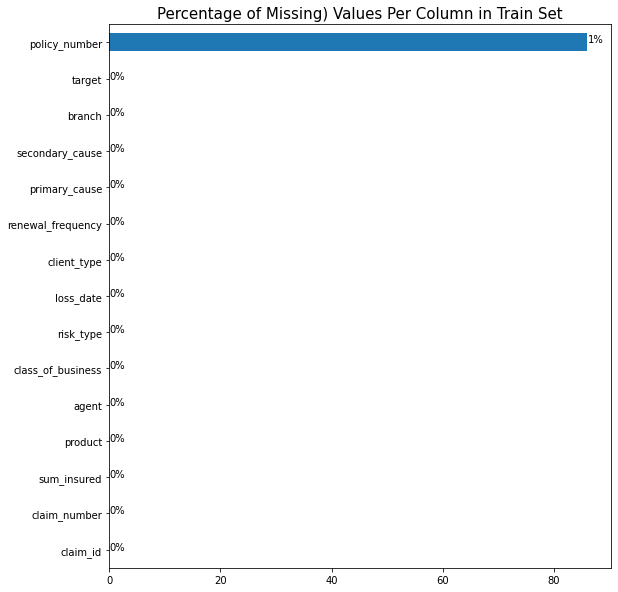

In [ ]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing) Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values

In [ ]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any(), policies.duplicated().any()

(False, False, False)

<a name="Outliers"></a>
## 5. Outliers

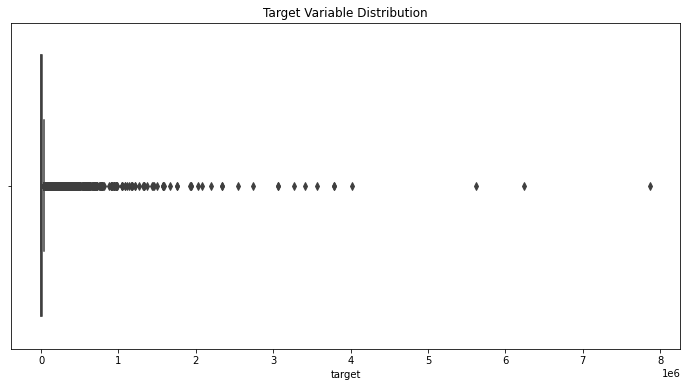

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.target)
plt.title('Target Variable Distribution');

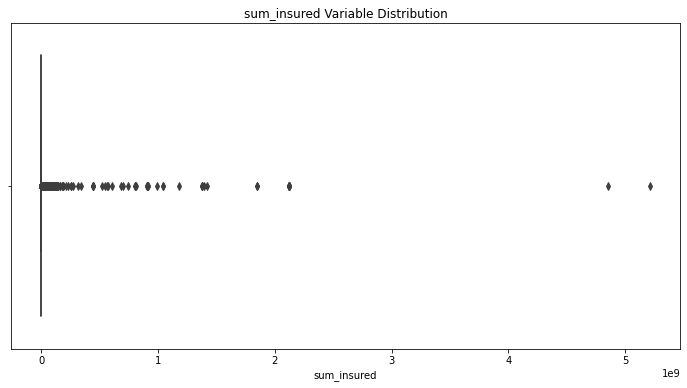

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.sum_insured)
plt.title('sum_insured Variable Distribution');

In [ ]:
Q1 = np.percentile(new_all_data_train['target'], 25,interpolation = 'midpoint')
 
Q3 = np.percentile(new_all_data_train['target'], 75,interpolation = 'midpoint')
IQR = Q3 - Q1

upper = np.where(new_all_data_train['target'] >= (Q3+1.5*IQR))
new_all_data_train.drop(upper[0], inplace = True)
print("New Shape: ", new_all_data_train.shape)

New Shape:  (7873, 17)


In [ ]:
new_all_data_train[new_all_data_train['sum_insured'].max() == new_all_data_train['sum_insured']]

,claim_id,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target,product_code,trans_date,from_date,to_date
7510,ID_KYLA5ZAN43E5,5211867675.00000,prod00002,ag00037,cob00004,rt00001,2019-12-31,ct0001,rf0002,pc0001,sc00010,br00001,0.00000,prod00002,2018-01-31 18:39:44.493,2018-01-01 00:00:00.000,2018-12-31 00:00:00.000


In [ ]:
new_all_data_train.drop(7510,inplace=True)

In [ ]:
resume_table(new_all_data_train)

(                 name   dtypes  missing  %missing  uniques
 0            claim_id   object        0   0.00000     7872
 1         sum_insured  float64        0   0.00000      990
 2             product   object        0   0.00000       35
 3               agent   object        0   0.00000        8
 4   class_of_business   object        0   0.00000       35
 5           risk_type   object        0   0.00000       48
 6           loss_date   object        0   0.00000     1272
 7         client_type   object        0   0.00000        3
 8   renewal_frequency   object        0   0.00000        5
 9       primary_cause   object        0   0.00000       19
 10    secondary_cause   object        0   0.00000       72
 11             branch   object        0   0.00000       11
 12             target  float64        0   0.00000     5190
 13       product_code   object       85   1.08000       35
 14         trans_date   object       85   1.08000     3746
 15          from_date   object       85

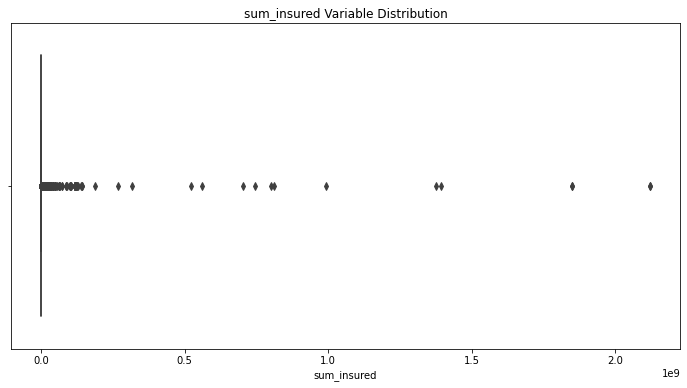

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.sum_insured)
plt.title('sum_insured Variable Distribution');

In [ ]:
new_all_data_train.shape

(7872, 17)

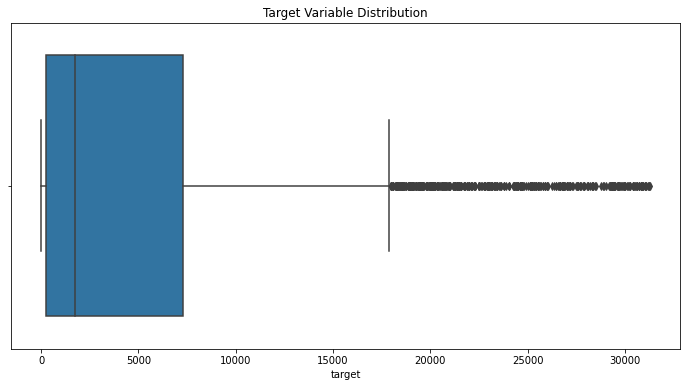

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.target)
plt.title('Target Variable Distribution');

In [ ]:
new_all_data_train['sum_insured'] = np.log(new_all_data_train['sum_insured'])

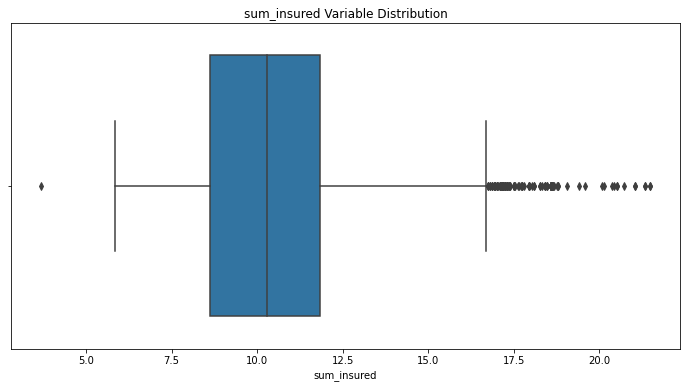

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.sum_insured)
plt.title('sum_insured Variable Distribution');

In [ ]:
a=(new_all_data_train[new_all_data_train['sum_insured'].min() == new_all_data_train['sum_insured']] ).index.values

In [ ]:
b=(new_all_data_train[new_all_data_train['sum_insured']< 10] ).index.values

In [ ]:
new_all_data_train.drop(b,inplace=True)

In [ ]:
#new_all_data_train.drop(a,inplace=True)

In [ ]:
Q1 = np.percentile(new_all_data_train['sum_insured'], 25,interpolation = 'midpoint')
 
Q3 = np.percentile(new_all_data_train['sum_insured'], 75,interpolation = 'midpoint')
IQR = Q3 - Q1

lower_2 = np.where(new_all_data_train['sum_insured'] <= (Q1-1.5*IQR))
upper_2 = np.where(new_all_data_train['sum_insured'] >= (Q3+1.5*IQR))

new_all_data_train.drop(lower_2[0], inplace = True)

print("New Shape: ", new_all_data_train.shape)

New Shape:  (4176, 17)


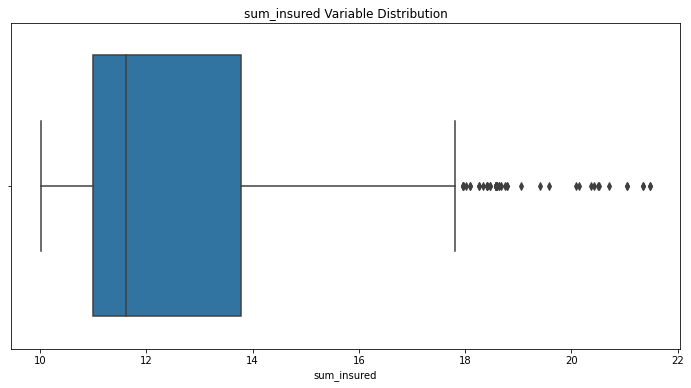

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.sum_insured)
plt.title('sum_insured Variable Distribution');

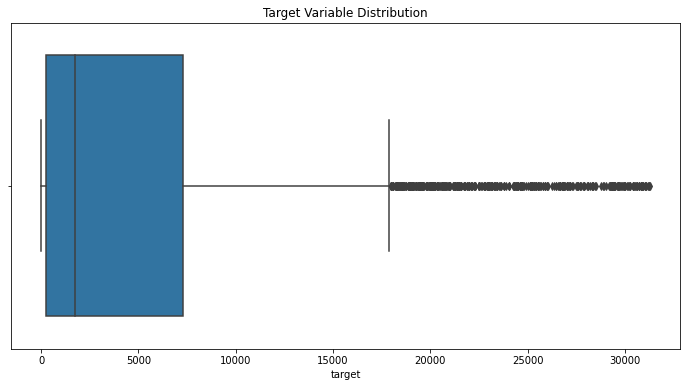

In [ ]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(new_all_data_train.target)
plt.title('Target Variable Distribution');

Outliers are those data points which differs significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...


<a name="Datatypes"></a>
## 6. Dataset datatypes

In [ ]:
cat_cols_zyada = train.columns.difference(['claim_id', 'loss_date', 'sum_insured', 'target','claim_number', 'policy_number']).tolist()

In [ ]:
new_all_data_train[cat_cols_zyada] = new_all_data_train[cat_cols_zyada].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols_zyada:
  new_all_data_train[col] = new_all_data_train[col].astype('category')


In [ ]:
new_all_data_test[cat_cols_zyada] = new_all_data_test[cat_cols_zyada].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols_zyada:
  new_all_data_test[col] = new_all_data_test[col].astype('category')


In [ ]:
# Train dataset datatypes
new_all_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4176 entries, 4 to 9371
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   claim_id           4176 non-null   object  
 1   sum_insured        4176 non-null   float64 
 2   product            4176 non-null   category
 3   agent              4176 non-null   category
 4   class_of_business  4176 non-null   category
 5   risk_type          4176 non-null   category
 6   loss_date          4176 non-null   object  
 7   client_type        4176 non-null   category
 8   renewal_frequency  4176 non-null   category
 9   primary_cause      4176 non-null   category
 10  secondary_cause    4176 non-null   category
 11  branch             4176 non-null   category
 12  target             4176 non-null   float64 
 13  product_code       4161 non-null   object  
 14  trans_date         4161 non-null   object  
 15  from_date          4161 non-null   object  
 16  to_dat

In [ ]:
# Convert datetime variables to datetime objects
new_all_data_train.loss_date = pd.to_datetime(new_all_data_train.loss_date, errors='coerce')

# Confirm that the dates have been converted successfully 
new_all_data_train.loss_date.describe()

count                    4176
unique                   1211
top       2019-03-16 00:00:00
freq                       19
first     2018-01-01 00:00:00
last      2021-10-18 00:00:00
Name: loss_date, dtype: object

In [ ]:
new_all_data_train.head()

,claim_id,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target,product_code,trans_date,from_date,to_date
4,ID_2OTD9NX8L73D,10.19802,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000,prod00015,2017-09-15 15:38:29.687,2017-10-01 00:00:00.000,2018-01-31 00:00:00.000
5,ID_H22FLDGRJ0JR,11.28978,prod00015,ag00037,cob00034,rt00023,2019-12-03,ct0001,rf0002,pc0002,sc00003,br00002,0.00000,prod00015,2018-01-12 16:04:44.230,2018-01-01 00:00:00.000,2018-12-31 00:00:00.000
6,ID_UQF7BGCES9AY,11.40756,prod00015,ag00064,cob00034,rt00023,2019-06-21,ct0001,rf0001,pc0007,sc00023,br00001,1185.84000,prod00015,2017-08-28 12:00:33.280,2017-08-01 00:00:00.000,2017-11-30 00:00:00.000
7,ID_HK7WLAIP5OXH,11.00210,prod00015,ag00226,cob00034,rt00023,2019-04-30,ct0001,rf0002,pc0007,sc00022,br00002,752.00000,prod00015,2017-07-13 09:00:22.967,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000
12,ID_Z6G03R6R4GSV,14.78135,prod00002,ag00068,cob00004,rt00001,2018-03-10,ct0001,rf0001,pc0001,sc00002,br00002,8920.62000,prod00002,2017-10-23 08:59:39.373,2017-10-01 00:00:00.000,2018-01-31 00:00:00.000


In [ ]:
resume_table(new_all_data_train)

(                 name          dtypes  missing  %missing  uniques
 0            claim_id          object        0   0.00000     4176
 1         sum_insured         float64        0   0.00000      870
 2             product        category        0   0.00000       30
 3               agent        category        0   0.00000        8
 4   class_of_business        category        0   0.00000       32
 5           risk_type        category        0   0.00000       39
 6           loss_date  datetime64[ns]        0   0.00000     1211
 7         client_type        category        0   0.00000        3
 8   renewal_frequency        category        0   0.00000        5
 9       primary_cause        category        0   0.00000       17
 10    secondary_cause        category        0   0.00000       64
 11             branch        category        0   0.00000       10
 12             target         float64        0   0.00000     2931
 13       product_code          object       15   0.36000     

In [ ]:
# Convert categorical variables to categorical objects
cat_cols_one_hot = ['agent','client_type','renewal_frequency','branch']

# Preview categorical variables
new_all_data_train[cat_cols_one_hot].head()

,agent,client_type,renewal_frequency,branch
4,ag00226,ct0001,rf0001,br00001
5,ag00037,ct0001,rf0002,br00002
6,ag00064,ct0001,rf0001,br00001
7,ag00226,ct0001,rf0002,br00002
12,ag00068,ct0001,rf0001,br00002


In [ ]:
new_all_data_train = pd.get_dummies(new_all_data_train, columns = cat_cols_one_hot)
new_all_data_test = pd.get_dummies(new_all_data_test, columns = cat_cols_one_hot)

In [ ]:
new_all_data_train.head()

,claim_id,sum_insured,product,class_of_business,risk_type,loss_date,primary_cause,secondary_cause,target,product_code,...,branch_br00001,branch_br00002,branch_br00003,branch_br00004,branch_br00005,branch_br00006,branch_br00007,branch_br00008,branch_br00009,branch_br00011
4,ID_2OTD9NX8L73D,10.19802,prod00015,cob00034,rt00023,2018-11-07,pc0007,sc00021,1605.64000,prod00015,...,1,0,0,0,0,0,0,0,0,0
5,ID_H22FLDGRJ0JR,11.28978,prod00015,cob00034,rt00023,2019-12-03,pc0002,sc00003,0.00000,prod00015,...,0,1,0,0,0,0,0,0,0,0
6,ID_UQF7BGCES9AY,11.40756,prod00015,cob00034,rt00023,2019-06-21,pc0007,sc00023,1185.84000,prod00015,...,1,0,0,0,0,0,0,0,0,0
7,ID_HK7WLAIP5OXH,11.00210,prod00015,cob00034,rt00023,2019-04-30,pc0007,sc00022,752.00000,prod00015,...,0,1,0,0,0,0,0,0,0,0
12,ID_Z6G03R6R4GSV,14.78135,prod00002,cob00004,rt00001,2018-03-10,pc0001,sc00002,8920.62000,prod00002,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
new_all_data_test.head()

,claim_id,sum_insured,product,class_of_business,risk_type,loss_date,primary_cause,secondary_cause,product_code,trans_date,...,branch_br00002,branch_br00003,branch_br00004,branch_br00005,branch_br00006,branch_br00007,branch_br00008,branch_br00009,branch_br00010,branch_br00011
0,ID_4RO0KZI9BBW2,300000.00000,prod00005,cob00009,rt00032,2021-03-11,pc0007,sc00029,prod00005,2020-11-19 15:55:50.350,...,0,0,1,0,0,0,0,0,0,0
1,ID_GTE9ZUJ9GZ97,2700000.00000,prod00015,cob00034,rt00023,2020-06-25,pc0007,sc00022,prod00015,2018-03-12 16:54:27.007,...,1,0,0,0,0,0,0,0,0,0
2,ID_RUVIYRKWZ4RG,4071352.00000,prod00012,cob00016,rt00015,2019-03-14,pc0011,sc00049,prod00012,2017-07-18 15:42:00.483,...,0,0,0,0,0,0,0,0,0,0
3,ID_J81X8SWU6JYN,0.00000,prod00002,cob00002,rt00002,2018-12-04,pc0002,sc00012,prod00002,2018-01-23 14:46:50.983,...,0,0,0,1,0,0,0,0,0,0
4,ID_94NM3JJAWWOQ,1607178.00000,prod00015,cob00034,rt00023,2019-09-18,pc0007,sc00022,prod00015,2017-10-30 17:07:24.717,...,1,0,0,0,0,0,0,0,0,0


<a name="Engineering"></a>
## 7. Feature engineering

In [ ]:
# Extract day, month and year from the loss date column
# day
new_all_data_train['loss_date_day'] = new_all_data_train.loss_date.dt.day

# month
new_all_data_train['loss_date_month'] = new_all_data_train.loss_date.dt.month
 
# year
new_all_data_train['loss_date_year'] = new_all_data_train.loss_date.dt.year

# Preview engineered date features
new_all_data_train[['loss_date', 'loss_date_day', 'loss_date_month', 'loss_date_year']].head()

,loss_date,loss_date_day,loss_date_month,loss_date_year
4,2018-11-07,7,11,2018
5,2019-12-03,3,12,2019
6,2019-06-21,21,6,2019
7,2019-04-30,30,4,2019
12,2018-03-10,10,3,2018


In [ ]:
# Convert datetime variables to datetime objects
new_all_data_test.loss_date = pd.to_datetime(new_all_data_test.loss_date, errors='coerce')


# Extract day, month and year from the loss date column
new_all_data_test['loss_date_day'] = new_all_data_test.loss_date.dt.day #day

new_all_data_test['loss_date_month'] = new_all_data_test.loss_date.dt.month #month
 
new_all_data_test['loss_date_year'] = new_all_data_test.loss_date.dt.year #year


<a name="Dates"></a>
## 8. Date features EDA

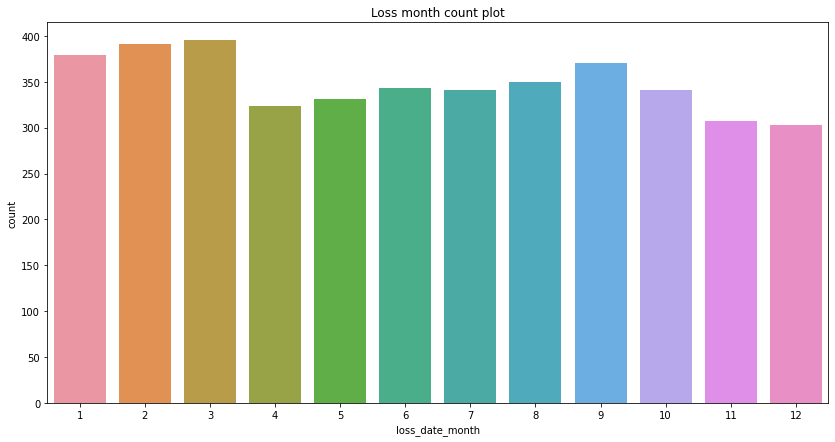

In [ ]:
# Loss month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'loss_date_month', data = new_all_data_train)
plt.title('Loss month count plot')
plt.show()

- June has the highest number of claims and December has the least number of claims

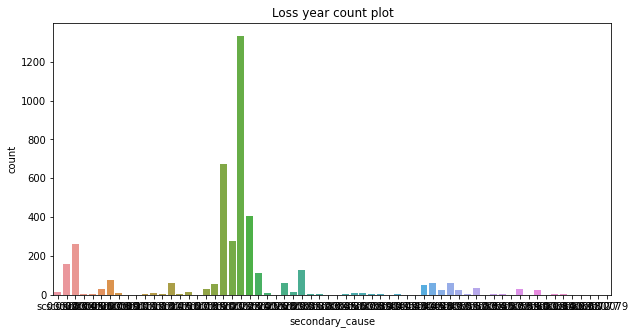

In [ ]:
# Loss year countplot
plt.figure(figsize = (10, 5))
sns.countplot(x = 'secondary_cause', data = new_all_data_train)
plt.title('Loss year count plot')
plt.show()

In [ ]:
new_all_data_train.head()

,claim_id,sum_insured,product,class_of_business,risk_type,loss_date,primary_cause,secondary_cause,target,product_code,...,branch_br00004,branch_br00005,branch_br00006,branch_br00007,branch_br00008,branch_br00009,branch_br00011,loss_date_day,loss_date_month,loss_date_year
4,ID_2OTD9NX8L73D,10.19802,prod00015,cob00034,rt00023,2018-11-07,pc0007,sc00021,1605.64000,prod00015,...,0,0,0,0,0,0,0,7,11,2018
5,ID_H22FLDGRJ0JR,11.28978,prod00015,cob00034,rt00023,2019-12-03,pc0002,sc00003,0.00000,prod00015,...,0,0,0,0,0,0,0,3,12,2019
6,ID_UQF7BGCES9AY,11.40756,prod00015,cob00034,rt00023,2019-06-21,pc0007,sc00023,1185.84000,prod00015,...,0,0,0,0,0,0,0,21,6,2019
7,ID_HK7WLAIP5OXH,11.00210,prod00015,cob00034,rt00023,2019-04-30,pc0007,sc00022,752.00000,prod00015,...,0,0,0,0,0,0,0,30,4,2019
12,ID_Z6G03R6R4GSV,14.78135,prod00002,cob00004,rt00001,2018-03-10,pc0001,sc00002,8920.62000,prod00002,...,0,0,0,0,0,0,0,10,3,2018


In [ ]:
new_all_data_train=new_all_data_train.drop(['loss_date','loss_date_year','loss_date_day'],axis=1)
new_all_data_test=new_all_data_test.drop(['loss_date','loss_date_year','loss_date_day'],axis=1)

In [ ]:
new_all_data_train=new_all_data_train.drop('secondary_cause',axis=1)
new_all_data_test=new_all_data_test.drop('secondary_cause',axis=1)

In [ ]:
new_all_data_train=new_all_data_train.drop(['trans_date','from_date','to_date'],axis=1)
new_all_data_test=new_all_data_test.drop(['trans_date','from_date','to_date'],axis=1)

In [ ]:
new_all_data_train.head()

,claim_id,sum_insured,product,class_of_business,risk_type,primary_cause,target,product_code,agent_ag00021,agent_ag00037,...,branch_br00002,branch_br00003,branch_br00004,branch_br00005,branch_br00006,branch_br00007,branch_br00008,branch_br00009,branch_br00011,loss_date_month
4,ID_2OTD9NX8L73D,10.19802,prod00015,cob00034,rt00023,pc0007,1605.64000,prod00015,0,0,...,0,0,0,0,0,0,0,0,0,11
5,ID_H22FLDGRJ0JR,11.28978,prod00015,cob00034,rt00023,pc0002,0.00000,prod00015,0,1,...,1,0,0,0,0,0,0,0,0,12
6,ID_UQF7BGCES9AY,11.40756,prod00015,cob00034,rt00023,pc0007,1185.84000,prod00015,0,0,...,0,0,0,0,0,0,0,0,0,6
7,ID_HK7WLAIP5OXH,11.00210,prod00015,cob00034,rt00023,pc0007,752.00000,prod00015,0,0,...,1,0,0,0,0,0,0,0,0,4
12,ID_Z6G03R6R4GSV,14.78135,prod00002,cob00004,rt00001,pc0001,8920.62000,prod00002,0,0,...,1,0,0,0,0,0,0,0,0,3


In [ ]:
resume_table(new_all_data_train)

(                        name    dtypes  missing  %missing  uniques
 0                   claim_id    object        0   0.00000     4176
 1                sum_insured   float64        0   0.00000      870
 2                    product  category        0   0.00000       30
 3          class_of_business  category        0   0.00000       32
 4                  risk_type  category        0   0.00000       39
 5              primary_cause  category        0   0.00000       17
 6                     target   float64        0   0.00000     2931
 7               product_code    object       15   0.36000       30
 8              agent_ag00021     uint8        0   0.00000        2
 9              agent_ag00037     uint8        0   0.00000        2
 10             agent_ag00044     uint8        0   0.00000        2
 11             agent_ag00064     uint8        0   0.00000        2
 12             agent_ag00068     uint8        0   0.00000        2
 13             agent_ag00080     uint8        0

- Most of the claims were done in the year 2018 and the least in the year 2021

<a name="Branch"></a>
## 9. Branch features EDA

- Branch 1 and 2 seem to have the highest number of outliers in the sum insured variable.
- This outliers might affect model performance, so its best to handle them

 - Most of the claims are concentrated in branch1 and branch2, so when modelling and creating new features, try to balance out the features to avoid overfitting

<a name="Categorical"></a>
## 10. Categorical features
*Try different strategies of dealing with categorical variables*
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

<a name="Preprocess"></a>
## 11.  Preprocess test dataset

In [ ]:



#Label encode categorical variables
# Instantiate Labelencoder
le = LabelEncoder()
new_all_data_train['risk_type'] = le.fit_transform(new_all_data_train['risk_type'])
new_all_data_train['product'] = le.fit_transform(new_all_data_train['product'])
new_all_data_train['class_of_business'] = le.fit_transform(new_all_data_train['class_of_business'])
new_all_data_train['primary_cause'] = le.fit_transform(new_all_data_train['primary_cause'])
new_all_data_train['product_code'] = le.fit_transform(new_all_data_train['primary_cause'])
 

new_all_data_test['product_code'] = le.fit_transform(new_all_data_test['product_code'])
new_all_data_test['risk_type'] = le.fit_transform(new_all_data_test['risk_type'])
new_all_data_test['product'] = le.fit_transform(new_all_data_test['product'])
new_all_data_test['class_of_business'] = le.fit_transform(new_all_data_test['class_of_business'])
new_all_data_test['primary_cause'] = le.fit_transform(new_all_data_test['primary_cause'])





#scaling

In [ ]:
resume_table(new_all_data_train)

(                        name   dtypes  missing  %missing  uniques
 0                   claim_id   object        0   0.00000     4176
 1                sum_insured  float64        0   0.00000      870
 2                    product    int64        0   0.00000       30
 3          class_of_business    int64        0   0.00000       32
 4                  risk_type    int64        0   0.00000       39
 5              primary_cause    int64        0   0.00000       17
 6                     target  float64        0   0.00000     2931
 7               product_code    int64        0   0.00000       17
 8              agent_ag00021    uint8        0   0.00000        2
 9              agent_ag00037    uint8        0   0.00000        2
 10             agent_ag00044    uint8        0   0.00000        2
 11             agent_ag00064    uint8        0   0.00000        2
 12             agent_ag00068    uint8        0   0.00000        2
 13             agent_ag00080    uint8        0   0.00000     

In [ ]:
new_all_data_test=new_all_data_test.drop('branch_br00010',axis=1)

In [ ]:
new_all_data_test=new_all_data_test.drop('claim_id',axis=1)
new_all_data_train=new_all_data_train.drop('claim_id',axis=1)

In [ ]:
resume_table(new_all_data_test)

(                        name   dtypes  missing  %missing  uniques
 0                sum_insured  float64        0   0.00000      820
 1                    product    int64        0   0.00000       34
 2          class_of_business    int64        0   0.00000       33
 3                  risk_type    int64        0   0.00000       43
 4              primary_cause    int64        0   0.00000       18
 5               product_code    int64        0   0.00000       35
 6              agent_ag00021    uint8        0   0.00000        2
 7              agent_ag00037    uint8        0   0.00000        2
 8              agent_ag00044    uint8        0   0.00000        2
 9              agent_ag00064    uint8        0   0.00000        2
 10             agent_ag00068    uint8        0   0.00000        2
 11             agent_ag00080    uint8        0   0.00000        2
 12             agent_ag00083    uint8        0   0.00000        2
 13             agent_ag00226    uint8        0   0.00000     

In [ ]:
new_all_data_test.head()

,sum_insured,product,class_of_business,risk_type,primary_cause,product_code,agent_ag00021,agent_ag00037,agent_ag00044,agent_ag00064,...,branch_br00002,branch_br00003,branch_br00004,branch_br00005,branch_br00006,branch_br00007,branch_br00008,branch_br00009,branch_br00011,loss_date_month
0,300000.00000,4,8,29,6,4,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
1,2700000.00000,12,28,20,6,12,0,0,0,1,...,1,0,0,0,0,0,0,0,0,6
2,4071352.00000,10,14,14,9,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0.00000,1,1,1,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,12
4,1607178.00000,12,28,20,6,12,0,1,0,0,...,1,0,0,0,0,0,0,0,0,9


In [ ]:
new_all_data_train.head()

,sum_insured,product,class_of_business,risk_type,primary_cause,target,product_code,agent_ag00021,agent_ag00037,agent_ag00044,...,branch_br00002,branch_br00003,branch_br00004,branch_br00005,branch_br00006,branch_br00007,branch_br00008,branch_br00009,branch_br00011,loss_date_month
4,10.19802,11,27,20,6,1605.64000,6,0,0,0,...,0,0,0,0,0,0,0,0,0,11
5,11.28978,11,27,20,1,0.00000,1,0,1,0,...,1,0,0,0,0,0,0,0,0,12
6,11.40756,11,27,20,6,1185.84000,6,0,0,0,...,0,0,0,0,0,0,0,0,0,6
7,11.00210,11,27,20,6,752.00000,6,0,0,0,...,1,0,0,0,0,0,0,0,0,4
12,14.78135,1,3,0,0,8920.62000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3


<a name="Modelling"></a>
## 12.  Modelling

In [ ]:
# Select main columns to be used in training
main_cols = new_all_data_train.columns.difference(['target']).tolist()
X = new_all_data_train[main_cols]
y = new_all_data_train.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the MAE score of the model
print(f'LinearRegression MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

LinearRegression MAE score on the X_test is: 5412.4528229665075


In [ ]:
# Select main columns to be used in training
main_cols = train.columns.difference(['claim_id', 'loss_date', 'target']).tolist()
X = train[main_cols]
y = np.log1p(train.target)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

# Train model

params = {
    'objective': 'mae',
    'n_estimators':100,
    'max_depth':5,
    'num_leaves':16,
    'learning_rate':0.2
}
model = LGBMRegressor(**params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)
y_pred[y_pred < 5] = 0
y_test = np.expm1(y_test)
# Check the MAE score of the model
print(f'LGBM Regressor MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from xgboost.sklearn import XGBRegressor

parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1,0.05,0.01], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

xgb_model = XGBRegressor(random_state=30)

grid_obj_xgb = RandomizedSearchCV(xgb_model,parameters, cv=5,n_iter=50,scoring='neg_mean_absolute_error',verbose=5,n_jobs=12)
grid_obj_xgb.fit(X_train, y_train,verbose = 1)

y_pred_train = grid_obj_xgb.predict(X_train)
y_pred_test = grid_obj_xgb.predict(X_test)
samplesubmission.target =  grid_obj_xgb.predict(new_all_data_test)
err_xgb_train=mean_absolute_error(y_train, y_pred_train, multioutput='raw_values')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
samplesubmission.to_csv("20 marsu 2ND submission.csv",index=False)

<a name="Predictions"></a>
## 13. Making predictions of the test set and creating a submission file

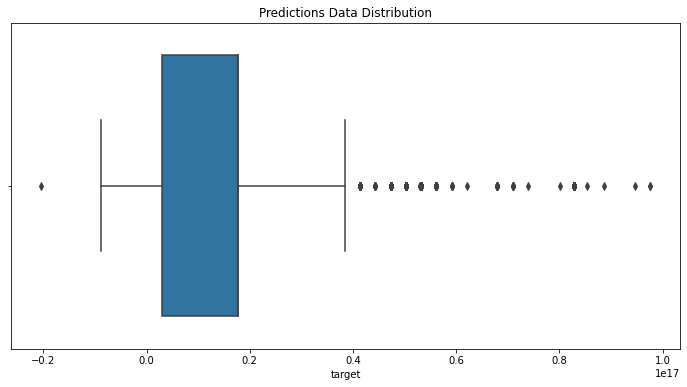

In [ ]:
# Make prediction on the test set
new_all_data_test = new_all_data_test[main_cols]
predictions = model.predict(new_all_data_test)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.target)
plt.title('Predictions Data Distribution');

 - There are some outliers in our predictions. 
 - More inspection/data preprocessing is needed

In [ ]:
# Preview the sub_file
sub_file.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,-5911303767697622.00000
1,ID_GTE9ZUJ9GZ97,17733913762172880.00000
2,ID_RUVIYRKWZ4RG,2955654767354459.00000
3,ID_J81X8SWU6JYN,-3637.00000
4,ID_94NM3JJAWWOQ,17733913015690804.00000


In [ ]:
# Write to csv file to submit to Zindi
sub_file.to_csv("Baseline.csv", index = False)

<a name="Tips"></a>
## 1. More Tips
- Use more data - policies data
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Ensembl4ing of models 
- Cross-validation: Group folds, Stratified...

# ******************* HAPPY HACKING ***************************